# Tension & Suspicion

In astrophysics and cosmology, we often bump against the limits of our understanding in the form of statistical _tensions_,  disagreements in the our results from two different data sources. There's two practical reasons we might care about tensions:
1. When asking if two measurements properly agree with one another
2. When considering if two data-sets are similar enough to pool them together

In the simplest of cases, like hubble tension diagram shown below, we can can use the rough yardstick of a **sigma tension**, $T$. Assuming our measurement uncertainties are gaussian, sigma-tension asks: <span style="font-family: verdana"><i>"how many standard deviations are result $A$ and result $B$ separated by"?</i></span>. The famous frequentist approach to this simple 1D case is to assign a P value based on how likely the separation is to be a product of coincidence:

$$
P = p(t > T) = \int_T^\infty \mathcal{N}(t) dt
$$

This a workable approach when our are simple one dimensional gaussians, but what about complicated, high dimensional multivariate models? For a generalizeable and principled approach to the question of tensoin, we need to turn to the test-stastics of Bayesian modelling. In this post, I introduce the reader to _bayesian suspiciousness_, a little known item in the bayesian tool-belt that is well suited to the vague priors endemic to cosmology.


 <p style="text-align: center; font-family: tahoma"><i>Are these data sets based on the same parameters</i></p>
 
 <figure>
    <img src="./media/hubbletension.png" width="400">
</figure>

<p style="text-align: center; font-family: arial;width: 600px; margin:0 auto;" ><b>Diagram showing how tension in measurements of the hubble parameter <a href="https://arxiv.org/pdf/2105.05208.pdf">Perivolaropoulos & Skara 2022</a></b></p>

In part one of this post, I introduce the unfamiliar reader to two of the more common tools of bayesian "goodness of fit": _evidence_ and _information_ (also sometimes called entropy or the [Kullback Leiber divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)", and demonstrate the shortfalls these have in measuring statistical tension. I then introduce bayesian suspiciousness, and show how it dodges the pitfalls of its better known cousins. In part 2, I derive all three tools for a simple 1D gaussian case to help offer an intuitive "feel" for what they represent. I extend this to the general multivariate case, and offer an interpretation of suspiciousness in P-value terms as an olive branch to the frequentists of the world.

In [1]:
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro
from matplotlib.patches import Ellipse

## Part 1: A Gentle Introduction to Suspiciousness by way of Example

Do two datasets _actually_ measure the same source? Can we combine them? Not always.
- Look at a simple example of a linear regression
- A casual glance suggests these are compatible, but digging in closer we run into trouble

- FROM HERE
- Plot contours, note existence of tension
- Not visible at first glance in 'c' contours. Typically approach of stating a '1 sigma tension' is unreliable in high dimensions
- Need a general purpose tool for detecting tension
- Will look at two tools and how they fail

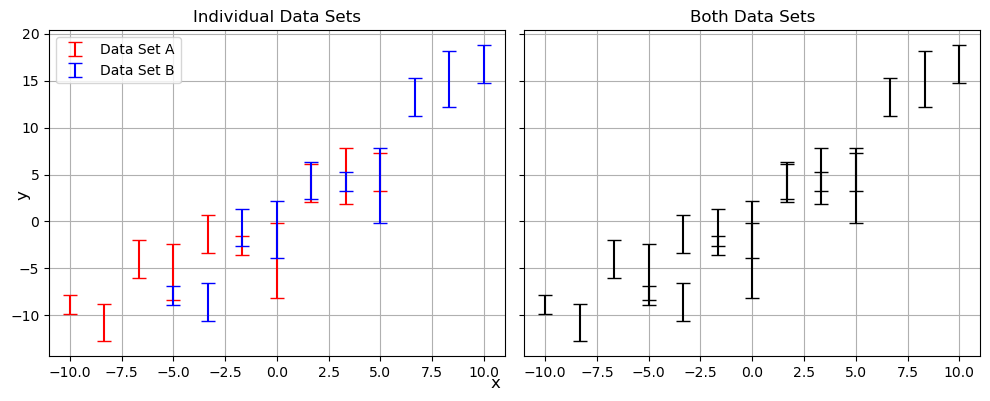

In [2]:
def gen_data(Ndata = 10, seed = 12, true_params = {'m':1,'c':0}, escatter=1, ebar = 1, Xrange= {-10,10}):
    np.random.seed(seed)
    m, c = true_params['m'], true_params['c']
    X = np.linspace(Xrange[0], Xrange[1], Ndata) 
    E = (np.random.poisson(lam=escatter, size=len(X))+1) / escatter * ebar + 0.01
    Y = m * X + c + E*np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'  
  
    return(X, Y, E) 

XA, YA, EA = gen_data(true_params = {'m':1,'c':0}, Xrange = [-10,5])
XB, YB, EB = gen_data(true_params = {'m':1.7,'c':-0.5}, Xrange = [-5,10])
XAB, YAB, EAB = np.concatenate([XA,XB]), np.concatenate([YA,YB]), np.concatenate([EA,EB])

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,4))
ax[0].errorbar(XA,YA,EA, fmt = 'none', c='r', capsize=5, label = "Data Set A")
ax[0].errorbar(XB,YB,EB, fmt = 'none', c='b', capsize=5, label = "Data Set B")
ax[1].errorbar(XAB,YAB,EAB, fmt = 'none', c='k', capsize=5, label = "Both Data Sets")
ax[0].grid()
ax[1].grid()

ax[0].set_title("Individual Data Sets")
ax[1].set_title("Both Data Sets")

ax[0].legend()

fig.tight_layout()
fig.supxlabel('x')
fig.supylabel('y')
plt.show()

## Bayesian Evidence 

We define a bayesian model and do MCMC, where "goodness of fit" of parameters $\theta$ is proporional to how well the model fits the data:

$$
P(\theta \vert y) \propto P(y \vert \theta) \cdot \pi(\theta)
$$

This has a proportionality constant $Z$, which we usually handwave away as we only care about the _relative_ performance of any two points in parameter space. However, this constant has physical meaning: It's the _total_ "mass of likelihood" of the entire posterior: 

$$
Z = \int \mathcal{L}(\theta \vert y)\cdot \pi(\theta) d\theta
$$

This is the **Bayesian Evidence**, and describes the overall ability of the model to explain / reproduce the data.

Because the evidence is a measure of how well a model performs overall, we can compare the performance of two models by looking at the ratio of these two. E.g, for models '1' and '2':

$$
R_{12} = \frac{Z_1}{Z_2}
$$

This **Evidence Ratio** gives us a direct comparison of two models. 

### Failure of Evidence Ratio in Measuring Tension

From a certain point of view, modelling two data sets together or separately can be considered a type of model comparison. Fitting them seperately is the same as saying "let data set A and B have different parameters". As such, we might consider using evidence ratios to measure tension by comparing these two "models" e.g.:

$$
R = \frac{Z_A Z_B}{Z_{AB}}
$$

The problem: suppose we have a vague prior with width '$a$':

$$
P(\theta \vert y) \propto \pi(\theta) \rightarrow Z \propto \frac{1}{a}
$$

This carries through to the evidence ratio:

$$
R = \frac{Z_A Z_B}{Z_{AB}} \propto \frac{a^{-1}\cdot a^{-1}}{a^{-1}} \propto a^{-1}
$$

The evidence ratio becommes "diluted" with wide priors.

## Information

Another measure is the information (also called the entropy or _Kullback-Lieber divergence_, plus or minus a negative sign) wich measures how well the model constrains the parameter $\theta$ as compared to a prior:

$$
    D_m = \int_\pi{P_m(\theta)\cdot \ln \left|\frac{P_m(\theta)}{\pi(\theta)} \right|}d\theta
$$

If $D_m>0$, this indicates that information has been 'gained' about $\theta$, i.e. that our data is meaningfully constraining the parameter compared to our prior. This information can be applied to cases of model selection in the case of two models that are the same but for the inclusion of some extra parameter. If the parameter is poorly constrained, i.e. the relative gain in information between the models is low, it indicates that the more complex model with the parameter included can be rejected.

### The Problem With Information

Information is _gained_ when our results are better constrained than the prior. A wider prior means _more_ information is gained.

$$
\exp(D) \propto a
$$

This propogates through to the _relative_ information gain:

$$
\Delta D = D_A + D_B - D_{AB}
$$

This has the opposite problem to the evidence ratio: it gets arbitrarily better as the prior becomes more vague:

$$
exp(\Delta D) \propto a
$$


# Suspiciousness

We can combine evidence and information to get a new measurement, **suspiciousness**

$$
S = ln \vert Z \vert - D
$$

This new measurement is **invariant with prior width**

$$
\Delta S = S_A + S_B - S_{AB} \propto a^0
$$

In [3]:
default_priors = {'m': [0.0,10],
                 'c': [0.0,20] }

def model(x,y,e, priors = default_priors):
    m_mu, m_sig = priors['m']
    c_mu, c_sig = priors['c']
    m = numpyro.sample('m', numpyro.distributions.Normal(m_mu,m_sig))
    c = numpyro.sample('c', numpyro.distributions.Normal(c_mu,c_sig))
    y_pred = m*x+c
    with numpyro.plate('data',len(x)):
        numpyro.sample('y', numpyro.distributions.Normal(y,e), obs=y_pred)

In [4]:
def get_KL(chain, poten, prior):
    Z = get_Z(chain, poten, prior)
    M, C = chain['m'], chain['c']
    m_mu, m_sig = prior['m']
    c_mu, c_sig = prior['c']
    log_like = -poten - np.log(Z)
    priorfunc = np.exp(-1/2 * (((M-m_mu)/m_sig)**2 + ((C-c_mu)/c_sig)**2)) / (2*np.pi) / c_sig / m_sig

    out = (np.log(priorfunc) - log_like).mean()
    return(-out)

def get_Z(chain, poten, prior):
    M, C = chain['m'], chain['c']
    
    COV = np.cov(np.stack([M,C]))
    sig1, sig2 = np.sqrt(np.linalg.eig(COV).eigenvalues)
    
    out = np.exp(-poten).max() * (sig1*sig2 * 2*np.pi)
    return(out)

In [5]:
sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(model),
                             num_samples = 100000,
                             num_warmup = 500,
                             num_chains = 1,
                             progress_bar = False)

print("Doing Set A")
sampler.run(jax.random.PRNGKey(1), XA,YA,EA, extra_fields = ("potential_energy",))
res_A = sampler.get_samples()
poten_A = sampler.get_extra_fields()['potential_energy']
D_A = get_KL(res_A, poten_A, default_priors)
Z_A = get_Z(res_A, poten_A, default_priors)

print("Doing Set B")
sampler.run(jax.random.PRNGKey(1), XB,YB,EB, extra_fields = ("potential_energy",))
res_B = sampler.get_samples()
poten_B = sampler.get_extra_fields()['potential_energy']
D_B = get_KL(res_B, poten_B, default_priors)
Z_B = get_Z(res_B, poten_B, default_priors)

print("Doing Both Sets")
sampler.run(jax.random.PRNGKey(1), XAB,YAB,EAB, extra_fields = ("potential_energy",))
res_AB = sampler.get_samples()
poten_AB = sampler.get_extra_fields()['potential_energy']
D_AB = get_KL(res_AB, poten_AB, default_priors)
Z_AB = get_Z(res_AB, poten_AB, default_priors)
print("Done")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Doing Set A
Doing Set B
Doing Both Sets
Done


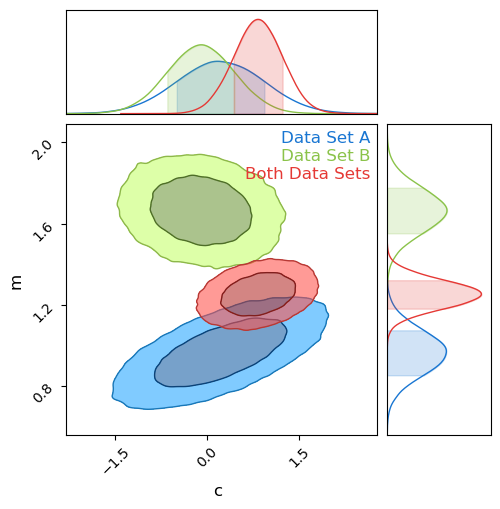

Evidence Ratio: 1.4196e-02
Relative Information Gain: 6.3187


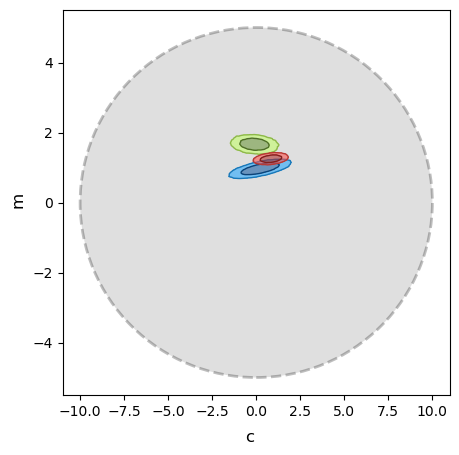

In [6]:
C = ChainConsumer()
C.add_chain(res_A, name = "Data Set A")
C.add_chain(res_B, name = "Data Set B")
C.add_chain(res_AB, name = "Both Data Sets")
C.plotter.plot(figsize=(5,5))
plt.show()


rel_inf = D_A+D_B - D_AB

Zrat = Z_A*Z_B / Z_AB
Zrat**=-1

print("Evidence Ratio: %.4e" %Zrat)
print("Relative Information Gain: %.4f" %(rel_inf))

fig, ax = plt.subplots(1,1, figsize=(5,5))
C.plotter.plot_contour(ax, 'c', 'm')
ellipse = Ellipse(xy=(default_priors['c'][0], default_priors['m'][0]), width=default_priors['c'][1], height=default_priors['m'][1], 
                        edgecolor='k', ls='--', fc='grey', alpha = 0.25, lw=2, label="1 sigma prior width", zorder=-10)
ax.add_patch(ellipse)
fig.supxlabel('c')
fig.supylabel('m')
plt.show()


In [7]:
expanded_priors = {'m':[0.0,100.0],
                      'c': [0.0,200.0] 
}

print("Doing Set A")
sampler.run(jax.random.PRNGKey(1), XA,YA,EA, extra_fields = ("potential_energy",), priors=expanded_priors)
res_A2 = sampler.get_samples()
poten_A2 = sampler.get_extra_fields()['potential_energy']
D_A2 = get_KL(res_A2, poten_A2, expanded_priors)
Z_A2 = get_Z(res_A2, poten_A2, expanded_priors)

print("Doing Set B")
sampler.run(jax.random.PRNGKey(1), XB,YB,EB, extra_fields = ("potential_energy",), priors=expanded_priors)
res_B2 = sampler.get_samples()
poten_B2 = sampler.get_extra_fields()['potential_energy']
D_B2 = get_KL(res_B2, poten_B2, expanded_priors)
Z_B2 = get_Z(res_B2, poten_B2, expanded_priors)

print("Doing Both Sets")
sampler.run(jax.random.PRNGKey(1), XAB,YAB,EAB, extra_fields = ("potential_energy",), priors=expanded_priors)
res_AB2 = sampler.get_samples()
poten_AB2 = sampler.get_extra_fields()['potential_energy']
D_AB2 = get_KL(res_AB2, poten_AB2, expanded_priors)
Z_AB2 = get_Z(res_AB2, poten_AB2, expanded_priors)

print("Done")

Doing Set A
Doing Set B
Doing Both Sets
Done


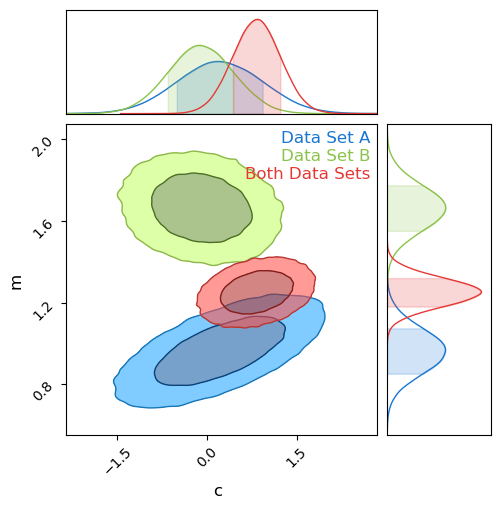

Evidence Ratio: 1.3865e+00
Relative Information Gain: 10.8864


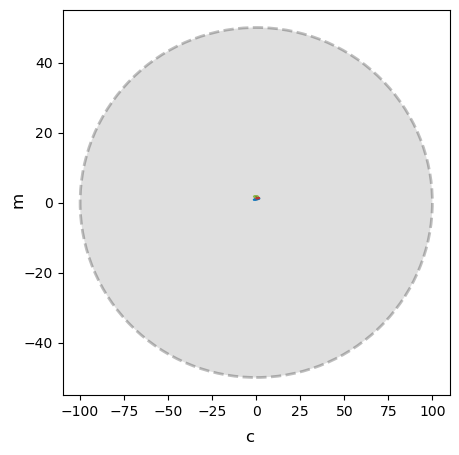

In [8]:
C2 = ChainConsumer()
C2.add_chain(res_A2, name = "Data Set A")
C2.add_chain(res_B2, name = "Data Set B")
C2.add_chain(res_AB2, name = "Both Data Sets")
C2.plotter.plot(figsize=(5,5))
plt.show()

rel_inf2 = D_A2+D_B2 - D_AB2

Zrat2 = Z_A2*Z_B2 / Z_AB2
Zrat2**=-1

print("Evidence Ratio: %.4e" %Zrat2)

print("Relative Information Gain: %.4f" %(rel_inf2))

fig, ax = plt.subplots(1,1, figsize=(5,5))
C2.plotter.plot_contour(ax, 'c', 'm')
ellipse = Ellipse(xy=(expanded_priors['c'][0], expanded_priors['m'][0]), width=expanded_priors['c'][1], height=expanded_priors['m'][1], 
                        edgecolor='k', ls='--', fc='grey', alpha = 0.25, lw=2, label="1 sigma prior width", zorder=-10)
ax.add_patch(ellipse)
fig.supxlabel('c')
fig.supylabel('m')
plt.show()


In [10]:
print("Suspiciousness for Prior 1: %.4f" %(np.log(Zrat) - rel_inf))
print("Suspiciousness for Prior 2: %.4f" %(np.log(Zrat2) - rel_inf2))

Suspiciousness for Prior 1: -10.5735
Suspiciousness for Prior 2: -10.5596


## Part 2: Translating to Frequentism - Interpreting Suspiciousness with P Values

- Derive with a 1D gaussian

$$
\mathcal{L}_A(x)= \frac{S_A}{\sqrt{2 \pi \sigma_A^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2 \right)}, \;\;\;
\mathcal{L}_B(x)= \frac{S_B}{\sqrt{2 \pi \sigma_B^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_B}{\sigma_B}\right)^2 \right)}
$$



The likelihood for the two combined data sets is just the product of these, another gaussian of the form:

$$
\mathcal{L}_{AB}(x)= \frac{S_{AB}}{\sqrt{2 \pi \sigma_{AB}^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_{AB}}{\sigma_{AB}}\right)^2 \right)}
$$

With the mean '$\mu_{AB}$' and standard deviation '$\sigma_{AB}$' based on the inverse-variance weighted average of the two:

$$
\mu_{AB} = \left(\frac{\mu_A}{\sigma_A^2} + \frac{\mu_B}{\sigma_B^2}\right)\cdot \sigma_{AB}^2, \;\;\; 
\sigma_{AB} = \left(\frac{1}{\sigma_A^2} + \frac{1}{\sigma_B^2}\right)^{-\frac{1}{2}}
$$

But with a scaling factor / integral:

$$
S_{AB} = S_A S_B \sqrt{2 \pi} \frac{\sigma_{AB}}{\sigma_A \sigma_B}
$$

By itself this isn't too illuminating, but can be rearranged into a more intuitive form:

$$
S_{AB} =S_A S_B \cdot \frac{1}{\sqrt{2 \pi (\sigma_A^2 + \sigma_B^2)^2}} \exp{ \frac{-1}{2} \left(\frac{(\mu_A-\mu_B)^2}{\sigma_A^2 + \sigma_B^2} \right)} = S_A S_B \cdot \mathcal{N}(T)
$$

Aside from the scaling factors we inherited $A$ and $B$, this is a direct measure of the sigma tension. The normal distribution here is the pdf that $\mu_A-\mu_B = 0$, the typical frequentist measure of whether $A$ and $B$ agree with eachother:

$$
T = \frac{\lvert \mu_A-\mu_B \rvert }{\sqrt{\sigma_A^2 + \sigma_B^2}}
$$

### Evidence Ratios

-Keep things simple with a uniform prior

$$
\pi(x) = 
    \begin{cases}
      \frac{1}{w} & \text{if } x\in \left[ -\frac{w}{2}, \frac{w}{2} \right]\\
      0 & \text{otherwise}
    \end{cases}       
$$

- As long as this prior is wide enough, our evidence will be "posterior dominated", making evidences easy to calculate

$$
Z_A = \frac{S_A}{w}, \;\;\; Z_B = \frac{S_B}{w}, \;\;\; Z_{AB} = \frac{S_{AB}}{w}
$$

$$
\mathcal{R} = \frac{Z_{AB}}{Z_A Z_B} = \frac{S_{AB}}{S_A S_B} \cdot w
$$

$$
\mathcal{R} = \mathcal{N}(T) \cdot w
$$

### Information

Information for data set $A$ is:

$$
I_A = \int_x { p_A(x) \ln{ \left( \frac{p_A(x)}{\pi(x)} \right) } } dx
= E \left[ \ln{ (p_A(x)) } - \ln{ (\pi(x)) } \right]_{p_A}
$$

Thanks to our simple example, the probabily normalized posterior for $A$ comes out to be a simple normal distribution:

$$
p_A(x) = \frac{\mathcal{L_A(x) \pi(x)}}{Z_A} = \frac{\mathcal{L_A (x)}}{S_A} = \frac{1}{\sqrt{2 \pi \sigma_A^2}} \exp{ \left( \frac{-1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2 \right)}
$$

As such, this expectation value mostly breaks down into constants:

$$
\ln{ (p_A(x)) }= -\frac{1}{2} \ln{ (2 \pi \sigma_A) }-\frac{1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2, \;\;\; \ln{ (\pi(x)) } = -\ln(w)
$$


\begin{eqnarray}
I_A &=& E \left[ \ln{ (p_A(x)) } - \ln{ (\pi(x)) } \right]_{p_A}
 &=& 
 - E \left[\frac{1}{2} \ln{ (2 \pi \sigma_A) } \right]_{p_A}
 - E \left[\frac{1}{2} \left(\frac{x-\mu_A}{\sigma_A}\right)^2 \right]_{p_A}
 + E \left[\ln{w} \right]_{p_A}
\end{eqnarray}

$$
I_A = \ln(w) - \ln(\sigma_A) - \frac{1}{2} (\ln(2\pi) +1)
$$

$$
I_B = \ln(w) - \ln(\sigma_B) - \frac{1}{2} (\ln(2\pi) +1), \;\;\;
I_{AB} = \ln(w) + \frac{1}{2} \ln \left(\frac{1}{\sigma_A^2} + \frac{1}{\sigma_B^2}\right) - \frac{1}{2} (\ln(2\pi) +1)
$$


Yielding

$$
\Delta I = I_{AB} - I_A - I_B
= \frac{1}{2} (\ln(2\pi) +1) + \ln \left( \frac{\sigma_A \sigma_B}{\sigma_{AB}^2} \right) + \ln \left( \frac{\sigma_{AB}}{w} \right)
$$

### Suspiciousness &  P-Value

$$
\Delta S = \ln ( \mathcal{R}) + \Delta I
$$

$$
\Delta S = \frac{1}{2}-\frac{1}{2} \frac{(\mu_A-\mu_B)^2}{\sigma_A^2 + \sigma_B^2} 
= \frac{1}{2}-\frac{T}{2}
$$

- Suspciciousness recovers the sigma tension independent of the prior!
- Natural step to interpret this as a gaussian test statistic

$$
T =\sqrt{1-2 \Delta S}
$$

And then define a P value in the typical frequentist way:

$$
P = p(t > T) = \int_T^\infty \mathcal{N}(t) dt
$$

<p style="text-align: center">
<table style="text-align: center; font-family: courier; font-size: 11pt">
    <tr>
        <th> P-Value </th> <th>$\sigma$-Tension</th> <th>Suspiciousness</th>
    </tr>
    <tr>
        <th> 0.05 </th> <td>-1.645</td> <td>-0.853</td>
    </tr>
    <tr>
        <th> 0.01 </th> <td>-2.326</td> <td>-2.206</td>
    </tr>
    <tr>
        <th> 0.01 </th> <td>-3.090</td> <td>-4.275</td>
    </tr>
</table>
</p>

### Extending To Non-Guassian & Multiple Dimensions
A one dimensional gaussian may seem like an overly restrictive case, but consider:  
1. Any distribution can be reparametrized into a similarly dimensioned gaussian of arbitrary covariance  
2. Evidence and information, and by extension suspiciousness, remain invariant under reparameterization  
3. $\ln{\left|Z\right|}$, $I$ and $S$ compose linearly for uncorrelated joint distributions, such as those recovered by **(1)** 
4. Combining **(2)** and **(3)**, we know that the relative suspiciousness of any ‘D’ dimensional distribution obeys:  
    

$$
\Delta S_D=\sum_{i=1}^{D}{\Delta S_i}=\sum_{i=1}^{D}{\frac{1}{2}-\frac{1}{2}\frac{\left(\mu_{A,i}-\mu_{B,i}\right)^2}{\sigma_{A,i}^2+\sigma_{B,i}^2}}
$$

Or, rearranging:

$$
1-2\cdot\Delta S_D=\sum_{i=1}^{D}\frac{\left(\mu_{A,i}-\mu_{B,i}\right)^2}{\sigma_{A,i}^2+\sigma_{B,i}^2}
$$

$$
1-2\cdot\Delta S_D= \sum_{i=1}^{D} (T_i^2) = \chi^2_D
$$

$$
P\left(\Delta S_D\right)=1-\int_{1-2\cdot\Delta S_D}^{\infty}{\chi_D^2\left(\Delta s^\prime\right)}d\Delta s^\prime
$$